In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
from importlib import reload
import datasets

import data_generator
import utils
import models
import lightning_module

# Useful to reload modified external files without need
# of restarting the kernel. Just run again this cell.
reload(datasets)

reload(data_generator)
reload(utils)

reload(models)
reload(lightning_module)

from datasets import *
from data_generator import SRDataset,NormalizePair,ComposePair

from utils import prepare_dataloaders
from models import *

import torch.nn as nn
import torch.nn.functional as F
import torch
import gc
from matplotlib import pyplot as plt
from math import log10
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger, CSVLogger
from pytorch_lightning import Trainer
from lightning_module import ESRGANLightning
from pytorch_lightning.callbacks import ModelCheckpoint
from torchsummary import summary

gc.collect()
torch.cuda.empty_cache() 
torch.set_float32_matmul_precision('high') # Set precision for matmul operations to 'high' for better performance


# Set the seed for reproducibility
SEED = 42
BATCH_SIZE = 1
NUM_WORKERS = 4
MANIFEST_PATH = "data_map.csv"
ROOT_DIR = "Dataset-2348-2x-10m-05m"


NORMALIZE_MEAN_LR = [0.0, 0.0, 0.0, 0.0]
NORMALIZE_STD_LR  = [1.0, 1.0, 1.0, 1.0]

NORMALIZE_MEAN_HR = [0.0, 0.0, 0.0, 0.0]
NORMALIZE_STD_HR  = [1.0, 1.0, 1.0, 1.0]

# _,_,_, stats = prepare_dataloaders(
#     manifest_path=MANIFEST_PATH,
#     root_dir=ROOT_DIR,
#     seed=SEED,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     normalize_means_stds=None,  # or pass precomputed if available
#     load_and_split_manifest_fn=load_and_split_manifest,
#     SRDataset_class=SRDataset,
#     ComposePair_class=ComposePair,
#     NormalizePair_class=NormalizePair
# )



train_loader, val_loader, test_loader, stats = prepare_dataloaders(
    manifest_path=MANIFEST_PATH,
    root_dir=ROOT_DIR,
    seed=SEED,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    normalize_means_stds=(NORMALIZE_MEAN_LR, NORMALIZE_STD_LR, NORMALIZE_MEAN_HR, NORMALIZE_STD_HR),  # or pass precomputed if available
    load_and_split_manifest_fn=load_and_split_manifest,
    SRDataset_class=SRDataset,
    ComposePair_class=ComposePair,
    NormalizePair_class=NormalizePair
)


config_dict = {
    'scale_factor': 2, # Scale factor for super-resolution
    'lr': 0.0002,
    'b1': 0.9,
    'b2': 0.999,
    'hr_height': 256,
    'hr_width': 256,
    'channels': 4,  # Number of channels in the input images
    'residual_blocks': 23, # Number of residual blocks in the generator
    'discriminator_filters': [64, 128, 128, 256, 256], # Filters for the discriminator
    'warmup_batches': 500,
    'lambda_adv': 0.001,
    'lambda_pixel': 0.02,
    'lambda_content': 1.0, # Content loss weight L1 weight
    'vgg19_path': "../Pretrained/vgg19.pth",
    'NORMALIZE_MEAN_HR': NORMALIZE_MEAN_HR,
    'NORMALIZE_STD_HR': NORMALIZE_STD_HR,
    'images_saved_dir': "images/validation",
    'saved_models_dir': "saved_models",
}




model = ESRGANLightning(config_dict)

checkpoint_callback = ModelCheckpoint(
    monitor='val/psnr',
    dirpath='saved_models',
    filename='model_{epoch:02d}_psnr_{val/psnr:.2f}',
    save_top_k=5,
    mode='max'
)
logger = CSVLogger("logs", name="esrgan_experiment")
trainer = Trainer(
    default_root_dir=os.getcwd(),
    max_epochs=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=10,
    logger=logger,
    callbacks=[checkpoint_callback]
)
# CKPT_PATH = None  # Path to a checkpoint if you want to resume training
# trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path=CKPT_PATH)




[DEBUG] Received config dict with keys: dict_keys(['scale_factor', 'lr', 'b1', 'b2', 'hr_height', 'hr_width', 'channels', 'residual_blocks', 'discriminator_filters', 'warmup_batches', 'lambda_adv', 'lambda_pixel', 'lambda_content', 'vgg19_path', 'NORMALIZE_MEAN_HR', 'NORMALIZE_STD_HR', 'images_saved_dir', 'saved_models_dir'])


/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/debwa/Desktop/FINAL_ESR/ESR_GAN/RGBI/lightning_module.py:41: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` wil

In [2]:

# print(summary(model, input_size=(4, 256, 256), device="cpu"))

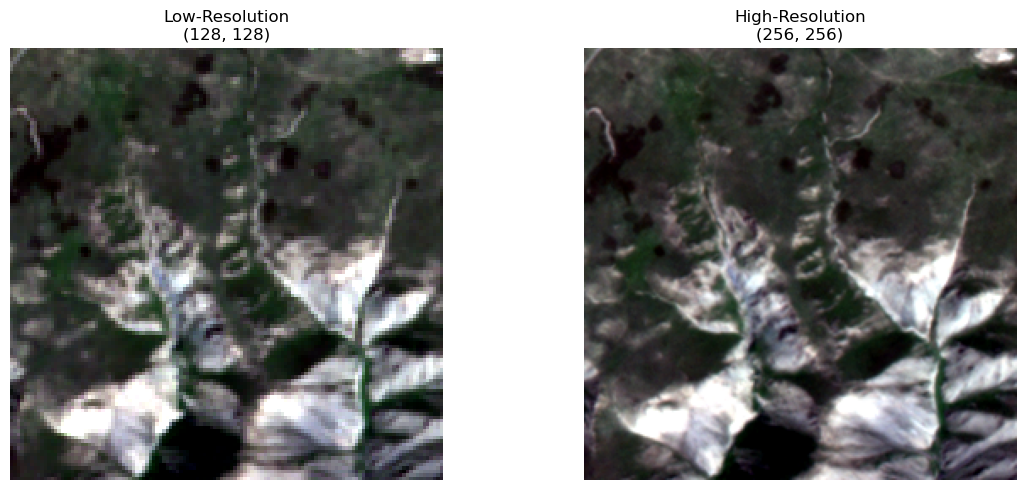

In [3]:
def visualize_rgb_pair(lr_tensor, hr_tensor, title_lr="Low-Resolution", title_hr="High-Resolution", display_bands=[0, 1, 2]):
    def apply_contrast_stretch(img, p1=2, p2=98):
        img_min = np.percentile(img, p1, axis=(0, 1), keepdims=True)
        img_max = np.percentile(img, p2, axis=(0, 1), keepdims=True)
        stretched = (img - img_min) / (img_max - img_min + 1e-6)
        return np.clip(stretched, 0, 1)

    def to_img(tensor):
        img = tensor[display_bands].cpu().numpy().transpose(1, 2, 0)
        return apply_contrast_stretch(img)

    lr_img = to_img(lr_tensor)
    hr_img = to_img(hr_tensor)

    plt.figure(figsize=(12, 5))
    for i, (img, title) in enumerate(zip([lr_img, hr_img], [title_lr, title_hr])):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img)
        plt.title(f"{title}\n{img.shape[:2]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
batch = next(iter(train_loader))
visualize_rgb_pair(batch['lr'][0], batch['hr'][0])

In [4]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def apply_contrast_stretch(img, p1=2, p2=98):
    img_min = np.percentile(img, p1, axis=(0, 1), keepdims=True)
    img_max = np.percentile(img, p2, axis=(0, 1), keepdims=True)
    stretched = (img - img_min) / (img_max - img_min + 1e-6)
    return np.clip(stretched, 0, 1)

def visualize_sr_triplets(model, test_loader, band_combination='2x', num_samples=3, dpi=150):
    band_configs = {
        '4x': {'display_bands': [3, 2, 1], 'label': "20m → 5m (B7/B6/B5)"},
        '2x': {'display_bands': [0, 1, 2], 'label': "10m → 5m (B4/B3/B2)"},
    }

    config = band_configs.get(band_combination.lower())
    if not config:
        raise ValueError("band_combination must be '2x' or '4x'.")

    model.eval().to(next(model.parameters()).device)
    shown = 0

    for batch in test_loader:
        if shown >= num_samples:
            break

        lr = batch['lr'].to(next(model.parameters()).device)
        hr = batch['hr'].to(next(model.parameters()).device)

        with torch.no_grad():
            sr = model(lr)

        for i in range(lr.size(0)):
            if shown >= num_samples:
                return

            def prep_img(t):  # Normalize and convert to HWC
                img = t[config['display_bands']].cpu().numpy()
                img = apply_contrast_stretch(img)
                return np.clip(img.transpose(1, 2, 0), 0, 1)

            lr_img = prep_img(lr[i])
            sr_img = prep_img(sr[i])
            hr_img = prep_img(hr[i])
            sr_img_raw = sr[i][config['display_bands']].cpu().numpy().transpose(1, 2, 0)
            hr_img_raw = hr[i][config['display_bands']].cpu().numpy().transpose(1, 2, 0)
            sr_img_raw = np.clip(sr_img_raw, 0, 1)
            hr_img_raw = np.clip(hr_img_raw, 0, 1)

            # Compute PSNR & SSIM between SR and HR
            psnr = peak_signal_noise_ratio(hr_img_raw, sr_img_raw, data_range=1.0)
            ssim_val = structural_similarity(hr_img_raw, sr_img_raw, data_range=1.0, channel_axis=-1, win_size=3)

            # Plot triplet
            titles = [
                f"LR (Upsampled)\n{lr_img.shape[:2]}",
                f"SR Output\nPSNR: {psnr:.2f} | SSIM: {ssim_val:.3f}",
                f"HR Ground Truth\n{hr_img.shape[:2]}"
            ]
            imgs = [lr_img, sr_img, hr_img]

            plt.figure(figsize=(18, 6), dpi=dpi)
            for j in range(3):
                plt.subplot(1, 3, j + 1)
                plt.imshow(imgs[j])
                plt.title(titles[j])
                plt.axis('off')
            # plt.suptitle(config['label'], fontsize=14)
            plt.tight_layout()
            plt.show()

            shown += 1


In [5]:
## FOR INFERENCE
test_model = ESRGANLightning(config_dict)
generator_path = "checkpoints/generator_epoch_57.pth" 
test_model.generator.load_state_dict(torch.load(generator_path, map_location='cpu'))


[DEBUG] Received config dict with keys: dict_keys(['scale_factor', 'lr', 'b1', 'b2', 'hr_height', 'hr_width', 'channels', 'residual_blocks', 'discriminator_filters', 'warmup_batches', 'lambda_adv', 'lambda_pixel', 'lambda_content', 'vgg19_path', 'NORMALIZE_MEAN_HR', 'NORMALIZE_STD_HR', 'images_saved_dir', 'saved_models_dir'])


/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/debwa/.conda/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/debwa/Desktop/FINAL_ESR/ESR_GAN/RGBI/lightning_module.py:41: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` wil

<All keys matched successfully>

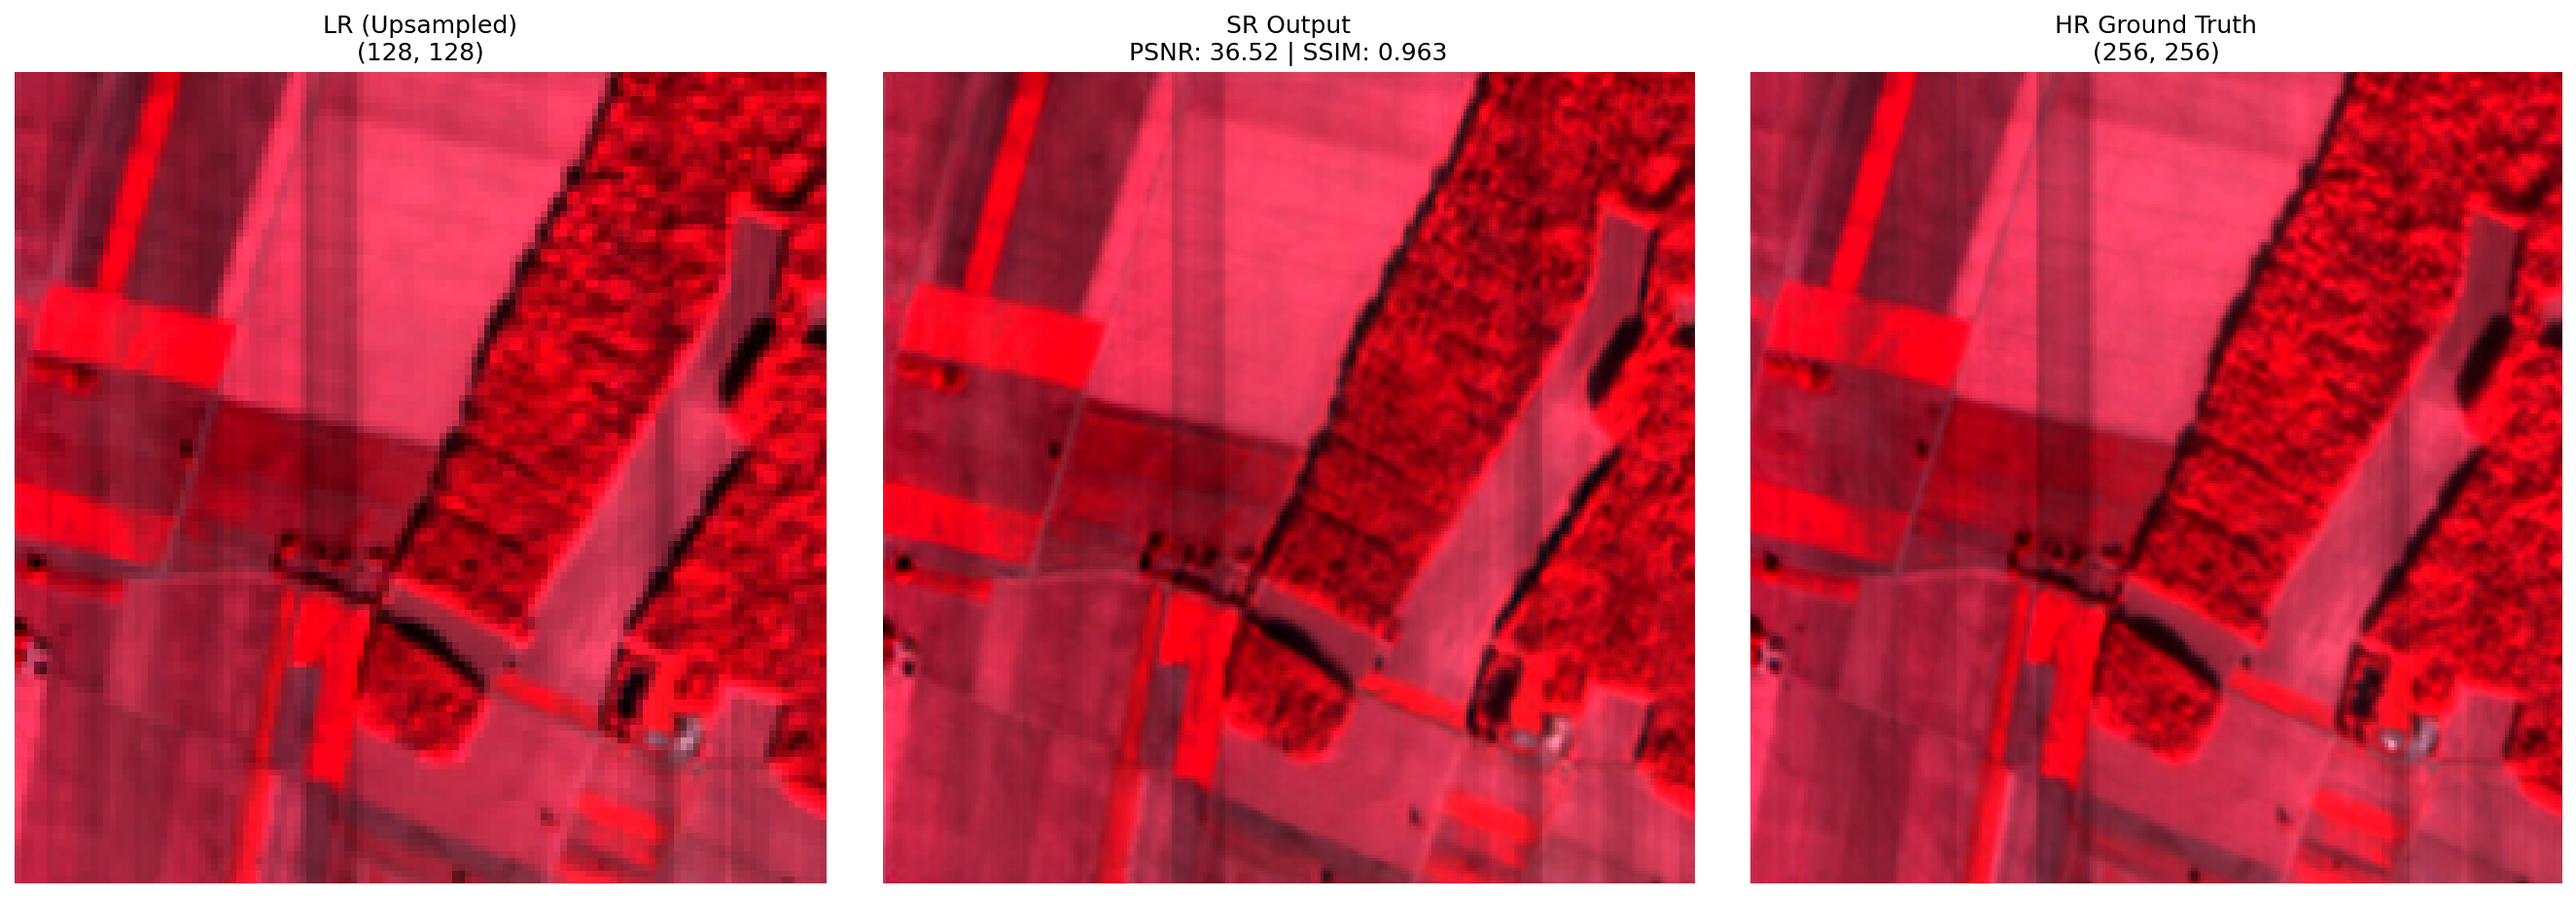

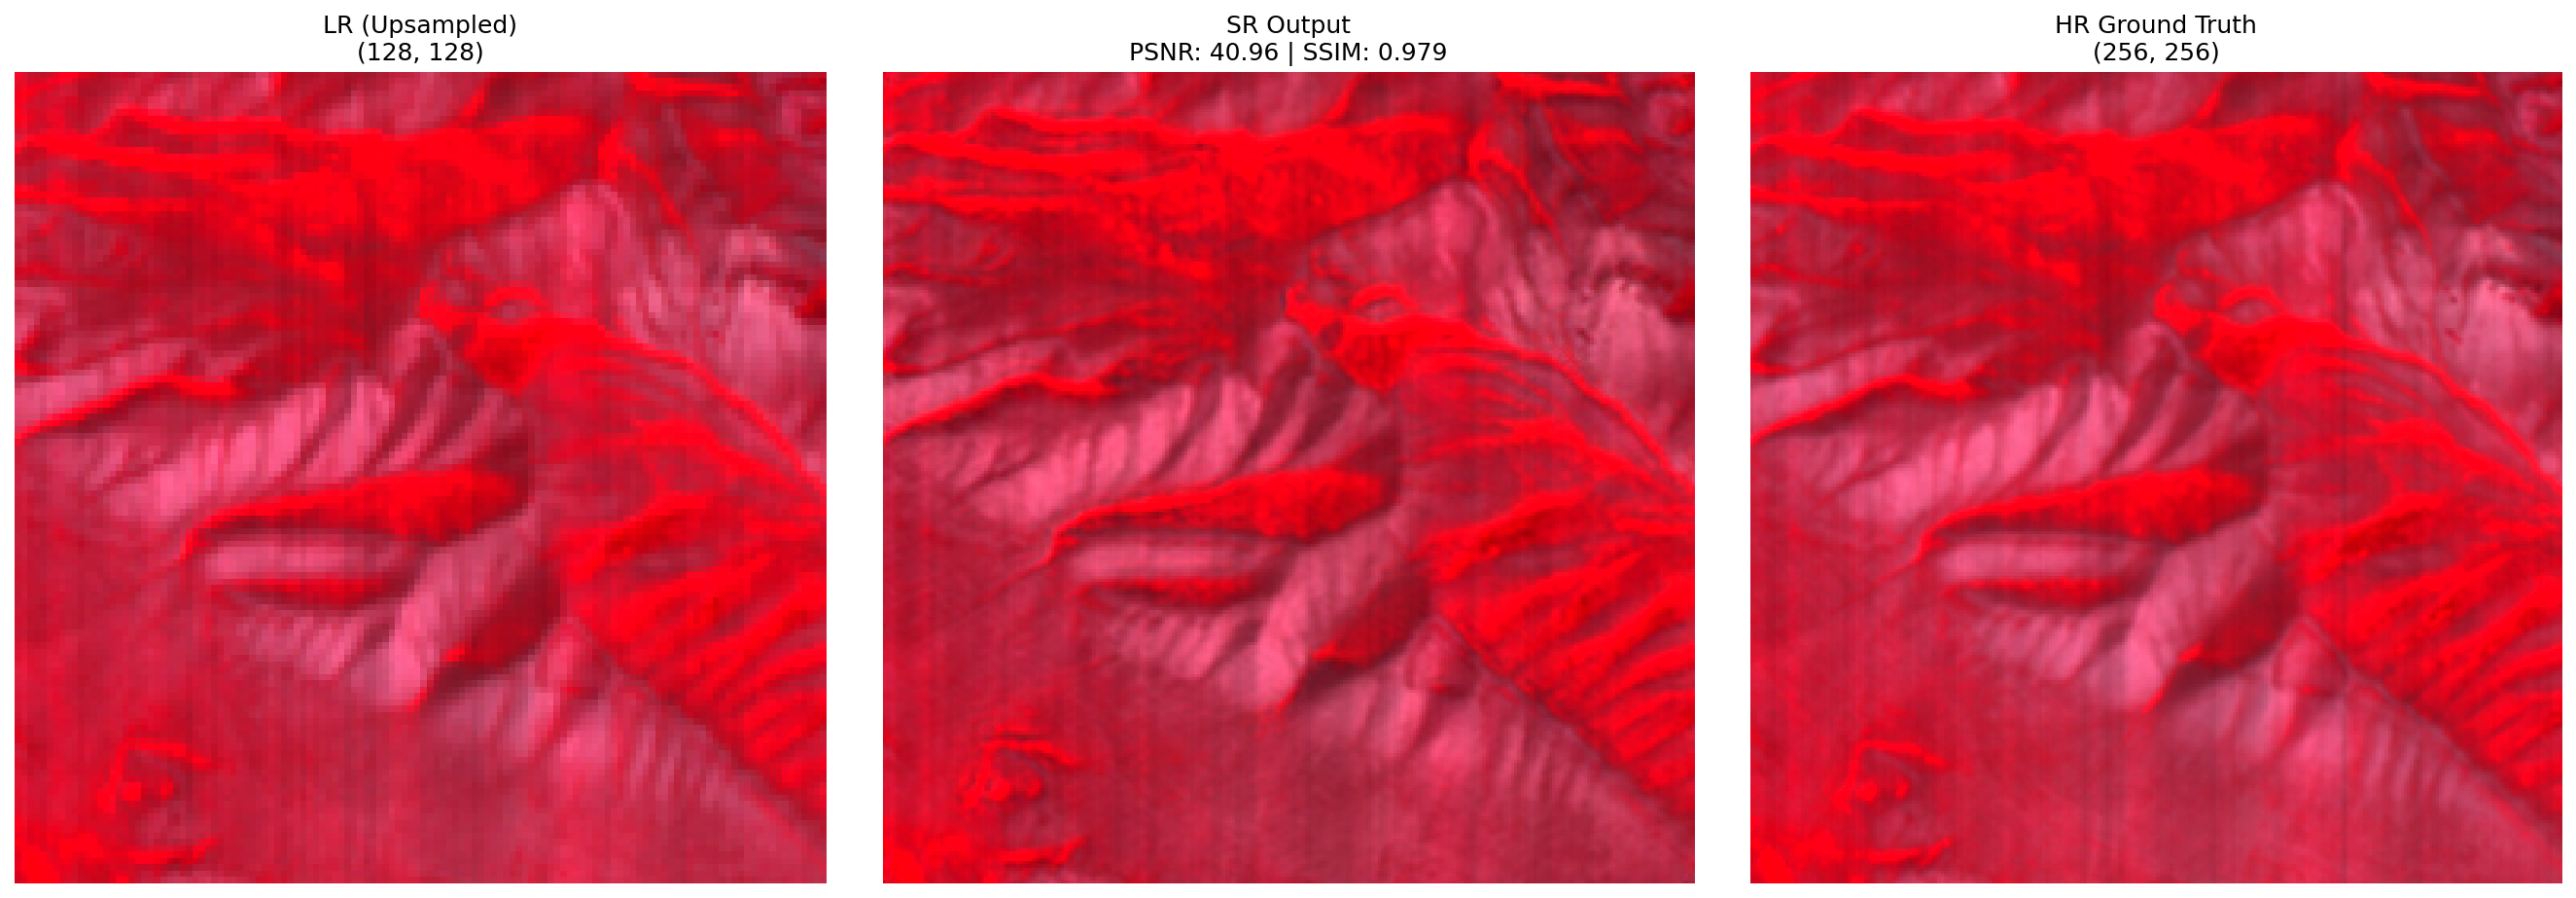

In [6]:
visualize_sr_triplets(test_model, test_loader, band_combination='4x', num_samples=2, dpi=150)

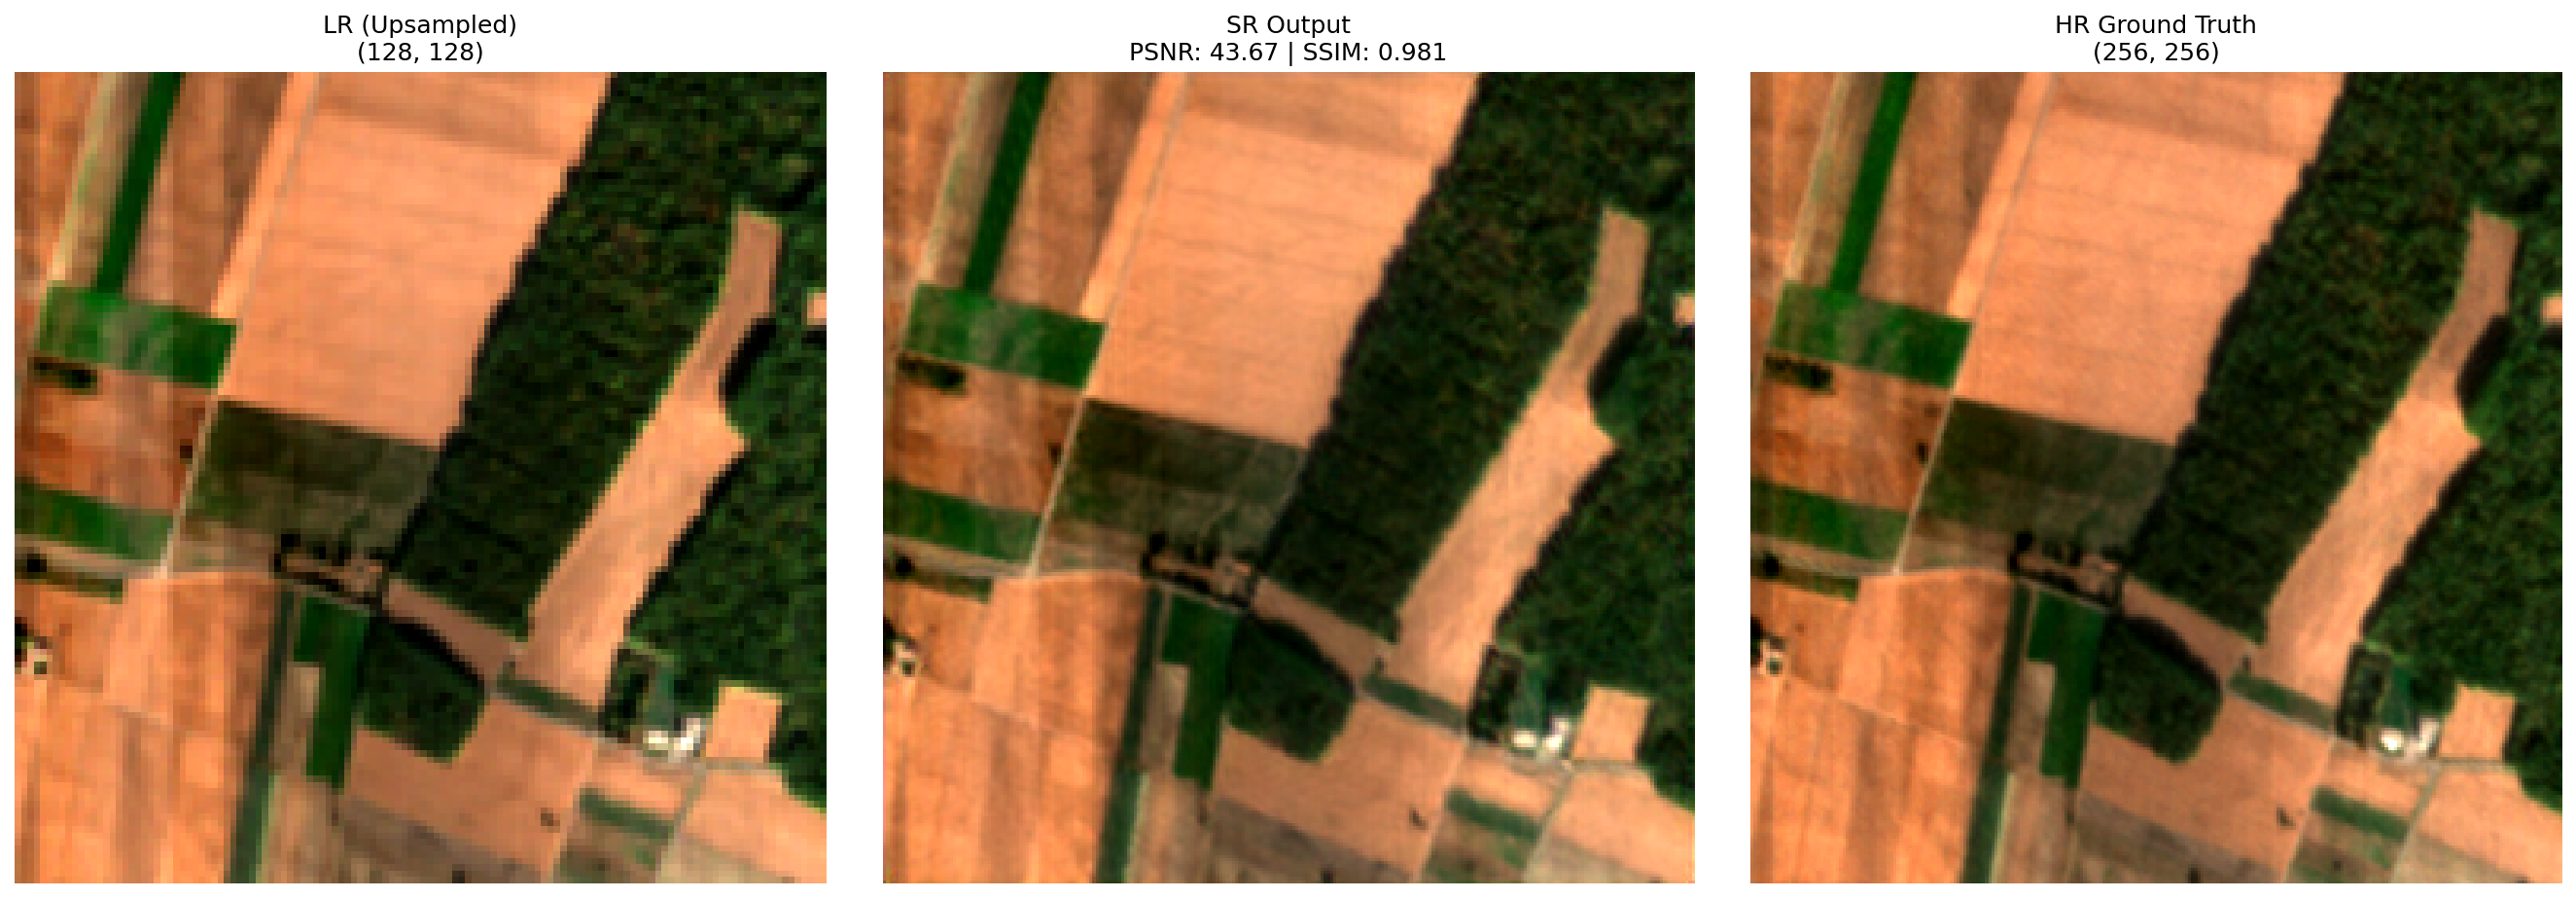

In [7]:
visualize_sr_triplets(test_model, test_loader, band_combination='2x', num_samples=1, dpi=150)
